In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/MultiModalImageSynthesis')

images_path = 'images/'
reports_path = 'reports/'

image_files = os.listdir(images_path)
report_files = os.listdir(reports_path)

print(f'Found {len(image_files)} images and {len(report_files)} reports.')

import xml.etree.ElementTree as ET
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_text(text):
    tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')
    input_ids = tokens['input_ids'].squeeze(0)
    attention_mask = tokens['attention_mask'].squeeze(0)

    input_ids = input_ids.unsqueeze(0)
    attention_mask = attention_mask.unsqueeze(0)

    return input_ids, attention_mask

class ChestXRayDataset(Dataset):
    def __init__(self, image_dir, xml_dir, transform=None):
        self.image_dir = image_dir
        self.xml_dir = xml_dir
        self.transform = transform
        self.data = []
        self._load_data()

    def _load_data(self):
        for xml_file in os.listdir(self.xml_dir):
            if xml_file.endswith(".xml"):
                xml_path = os.path.join(self.xml_dir, xml_file)
                tree = ET.parse(xml_path)
                root = tree.getroot()

                findings = root.find(".//AbstractText[@Label='FINDINGS']")
                impression = root.find(".//AbstractText[@Label='IMPRESSION']")

                if findings is not None and impression is not None:
                    findings_text = findings.text if findings.text else "No findings"
                    impression_text = impression.text if impression.text else "No impression"
                    text_data = f"Findings: {findings_text} Impression: {impression_text}"
                else:
                    text_data = "No text available"

                image_paths = []
                for parent_image in root.findall(".//parentImage"):
                    url = parent_image.find(".//url")
                    if url is not None:
                        filename = os.path.basename(url.text).replace('.jpg', '.png')
                        image_paths.append(filename)

                for img_file in image_paths:
                    img_path = os.path.join(self.image_dir, img_file)
                    if os.path.exists(img_path):
                        self.data.append((img_path, text_data))
                    else:
                        print(f"Image file not found: {img_path}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, text_data = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        text_input_ids, text_attention_mask = preprocess_text(text_data)
        text_input_ids = torch.tensor(text_input_ids, dtype=torch.long)
        text_attention_mask = torch.tensor(text_attention_mask, dtype=torch.long)
        return image, (text_input_ids, text_attention_mask)




image_dir = 'images/'
xml_dir = 'reports/'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# dataset = ChestXRayDataset(image_dir, xml_dir, transform=transform)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

from torch.utils.data import Subset, DataLoader
import torch

subset_size = 1000

dataset = ChestXRayDataset(image_dir, xml_dir, transform=transform)

indices = torch.randperm(len(dataset))[:subset_size]

subset = Subset(dataset, indices)

dataloader = DataLoader(subset, batch_size=32, shuffle=True)

Mounted at /content/drive
Found 7481 images and 3975 reports.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Residual Block Definition
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += identity  # Skip connection
        out = self.relu(out)
        return out

# Text Encoder
class TextEncoder(nn.Module):
    # def __init__(self, input_size, hidden_size, num_layers=2):
    #     super(TextEncoder, self).__init__()
    #     self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    #     self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        h, (hn, cn) = self.lstm(x)
        if h.dim() == 3:
            output = self.fc(h[:, -1, :])
        elif h.dim() == 2:
            output = self.fc(h)
        else:
            raise ValueError("Unexpected LSTM output shape")
        return output

# Image Encoder
class ImageEncoder(nn.Module):
    def __init__(self, hidden_size):
        super(ImageEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.res_block1 = ResidualBlock(128)
        self.res_block2 = ResidualBlock(128)
        self.fc = nn.Linear(128 * 56 * 56, hidden_size)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Image Generator
class ImageGenerator(nn.Module):
    def __init__(self, input_size):
        super(ImageGenerator, self).__init__()
        self.fc = nn.Linear(input_size, 128 * 56 * 56)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1)
        self.res_block1 = ResidualBlock(64)  # Add residual block after first deconvolution

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = x.view(x.size(0), 128, 56, 56)
        x = F.relu(self.deconv1(x))
        x = self.res_block1(x)  # Apply residual block
        x = self.deconv2(x)
        return torch.tanh(x)

# Image Discriminator
class ImageDiscriminator(nn.Module):
    def __init__(self):
        super(ImageDiscriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.fc = nn.Linear(128 * 56 * 56, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return torch.sigmoid(x)

# Multimodal GAN
class MultimodalGAN(nn.Module):
    def __init__(self, text_hidden_size, image_hidden_size):
        super(MultimodalGAN, self).__init__()
        self.text_encoder = TextEncoder(input_size=512, hidden_size=text_hidden_size, num_layers=2)  # BERT-base hidden size
        self.image_encoder = ImageEncoder(hidden_size=image_hidden_size)
        self.generator = ImageGenerator(input_size=text_hidden_size + image_hidden_size)
        self.discriminator = ImageDiscriminator()

    def forward(self, text, image):
        text_features = self.text_encoder(text)
        image_features = self.image_encoder(image)
        combined_features = torch.cat((text_features, image_features), dim=1)
        generated_image = self.generator(combined_features)
        return generated_image

    def discriminate(self, image):
        return self.discriminator(image)


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = MultimodalGAN(text_hidden_size=256, image_hidden_size=256).to(device)

# Loss functions
criterion = nn.BCELoss()
mse_loss = nn.MSELoss()

# Optimizers
optimizer_G = optim.Adam(model.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(model.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Labels for real and fake images
real_label = 1.0
fake_label = 0.0

# Number of epochs
num_epochs = 100

for epoch in range(num_epochs):
    for images, (text_input_ids, text_attention_mask) in dataloader:
        images = images.to(device)
        text_input_ids = text_input_ids.to(device)
        text_attention_mask = text_attention_mask.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real images
        output = model.discriminate(images).view(-1)
        loss_D_real = criterion(output, torch.full_like(output, real_label))

        # Generate fake images
        generated_images = model(text_input_ids.float(), images)
        output = model.discriminate(generated_images.detach()).view(-1)
        loss_D_fake = criterion(output, torch.full_like(output, fake_label))

        # Combine losses
        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        output = model.discriminate(generated_images).view(-1)
        loss_G = criterion(output, torch.full_like(output, real_label)) + mse_loss(generated_images, images) * 100
        loss_G.backward()
        optimizer_G.step()

    # Print losses
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

# Save model
torch.save(model.state_dict(), 'multimodal_gan_new.pth')


<ipython-input-1-fd73896ca91b>:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_input_ids = torch.tensor(text_input_ids, dtype=torch.long)
<ipython-input-1-fd73896ca91b>:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_attention_mask = torch.tensor(text_attention_mask, dtype=torch.long)


Epoch [1/100], Loss D: 0.2769, Loss G: 7.6406
Epoch [2/100], Loss D: 0.8642, Loss G: 4.7071
Epoch [3/100], Loss D: 0.4776, Loss G: 2.9909
Epoch [4/100], Loss D: 0.6969, Loss G: 1.7053
Epoch [5/100], Loss D: 0.5249, Loss G: 2.2350
Epoch [6/100], Loss D: 0.5443, Loss G: 2.0895
Epoch [7/100], Loss D: 0.5488, Loss G: 2.3223
Epoch [8/100], Loss D: 0.5647, Loss G: 1.7204
Epoch [9/100], Loss D: 0.6516, Loss G: 1.0830
Epoch [10/100], Loss D: 0.5819, Loss G: 1.4989
Epoch [11/100], Loss D: 0.5520, Loss G: 1.4615
Epoch [12/100], Loss D: 0.5882, Loss G: 1.5867
Epoch [13/100], Loss D: 0.5475, Loss G: 1.4720
Epoch [14/100], Loss D: 0.6653, Loss G: 1.5936
Epoch [15/100], Loss D: 0.5725, Loss G: 1.5953
Epoch [16/100], Loss D: 0.5819, Loss G: 1.6273
Epoch [17/100], Loss D: 0.5851, Loss G: 1.3866
Epoch [18/100], Loss D: 0.5323, Loss G: 1.8343
Epoch [19/100], Loss D: 0.6085, Loss G: 2.1651
Epoch [20/100], Loss D: 0.5022, Loss G: 1.2629
Epoch [21/100], Loss D: 0.5596, Loss G: 1.3635
Epoch [22/100], Loss D

In [ ]:
from google.colab import drive
import torch
import torchvision.transforms as transforms
from PIL import Image
from transformers import BertTokenizer

# Mount Google Drive
drive.mount('/content/drive')

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultimodalGAN(text_hidden_size=256, image_hidden_size=256).to(device)
model.load_state_dict(torch.load('/content/drive/My Drive/MultiModalImageSynthesis/multimodal_gan_new.pth', map_location=device))
model.eval()

# Test the model with a sample image and text
custom_image_path = '/content/drive/My Drive/MultiModalImageSynthesis/images/CXR85_IM-2372-1001.png'
custom_text_data = 'swollen heart'

# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Tokenizer setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_text(text):
    tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')
    input_ids = tokens['input_ids'].squeeze(0).unsqueeze(0)  # Add batch dimension
    attention_mask = tokens['attention_mask'].squeeze(0).unsqueeze(0)  # Add batch dimension
    return input_ids, attention_mask

# Load and preprocess image
try:
    image = Image.open(custom_image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
except Exception as e:
    print(f"Error loading image: {e}")

# Preprocess the text
text_input_ids, text_attention_mask = preprocess_text(custom_text_data)
text_input_ids = text_input_ids.to(device).float()

# Generate the synthetic image using the model
with torch.no_grad():
    generated_image = model(text_input_ids, image_tensor)

# Check and fix the shape of the generated image
generated_image = generated_image.squeeze(0)  # Remove batch dimension
if generated_image.shape[0] != 3:
    raise ValueError(f"Expected 3 channels, but got {generated_image.shape[0]} channels.")

# Convert to PIL Image
generated_image = (generated_image + 1) / 2  # Rescale to [0, 1]
generated_image = torch.clamp(generated_image, 0, 1)  # Ensure values are within [0, 1]
generated_image_pil = transforms.ToPILImage()(generated_image.cpu())

# Save the generated image
generated_image_pil.save('/content/drive/My Drive/MultiModalImageSynthesis/generated_xray.png')

print("Generated image saved as 'generated_xray.png'")

Mounted at /content/drive


<ipython-input-2-a6ba80a05211>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/MultiModalImageSynthesis/multimoda

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Generated image saved as 'generated_xray.png'


In [ ]:
import matplotlib.pyplot as plt
# Convert from [-1, 1] to [0, 1] for PIL conversion
generated_image = (generated_image + 1) / 2 # Rescale to [0, 1]
generated_image = torch.clamp(generated_image, 0, 1)  # Ensure values are within [0, 1]

# Convert to PIL Image for display
generated_image_pil = transforms.ToPILImage()(generated_image.cpu())

# Display the image using matplotlib
plt.imshow(generated_image_pil)
plt.axis('off')  # Turn off axis labels
plt.show()

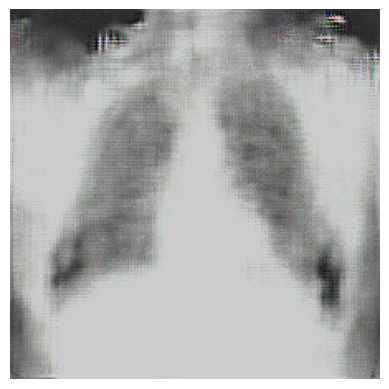

In [ ]:
import matplotlib.pyplot as plt
from PIL import ImageEnhance

# Enhance sharpness
sharpness_enhancer = ImageEnhance.Sharpness(generated_image_pil)
sharpened_image = sharpness_enhancer.enhance(4)  # Increase sharpness

# Enhance contrast
contrast_enhancer = ImageEnhance.Contrast(sharpened_image)
contrast_image = contrast_enhancer.enhance(5)  # Increase contrast

# Enhance brightness
brightness_enhancer = ImageEnhance.Brightness(contrast_image)
bright_image = brightness_enhancer.enhance(0.8)  # Increase brightness

# Enhance color (though it's grayscale, this step can still adjust tones)
color_enhancer = ImageEnhance.Color(bright_image)
enhanced_image = color_enhancer.enhance(1.0)  # No change to color (as it's grayscale)

# Display the final enhanced image
plt.imshow(enhanced_image)
plt.axis('off')  # Hide axis labels
plt.show()

# Save the final enhanced image
enhanced_image.save('enhanced_xray.png')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-7-ccc1a5bfd61a>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/MultiModalImageSynthesis/multimoda

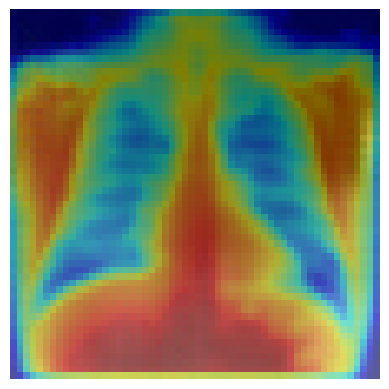

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from transformers import BertTokenizer

# Load your saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultimodalGAN(text_hidden_size=256, image_hidden_size=256).to(device)
model.load_state_dict(torch.load('/content/drive/My Drive/MultiModalImageSynthesis/multimodal_gan_new.pth', map_location=device))
model.eval()

# Define Grad-CAM functions (modified to target specific layers)
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradient = None
        self.activation = None
        self.hook_handles = []

        # Register hooks
        self._register_hooks()

    def _register_hooks(self):
        def save_activation(module, input, output):
            self.activation = output

        def save_gradient(module, grad_input, grad_output):
            self.gradient = grad_output[0]

        # Register hooks for the target layer
        self.hook_handles.append(self.target_layer.register_forward_hook(save_activation))
        self.hook_handles.append(self.target_layer.register_backward_hook(save_gradient))

    def clear_hooks(self):
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles = []

    def generate_cam(self, image_tensor, text_tensor):
    # Temporarily set model to training mode
        self.model.train()

        # Forward pass
        generated_image = self.model(text_tensor, image_tensor)

        # Backward pass
        self.model.zero_grad()
        generated_image.mean().backward()

        # Process gradients and activations for CAM
        weights = self.gradient.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activation).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()

        # Reset model to evaluation mode
        self.model.eval()

        return cam, generated_image


# Define target layer for Grad-CAM
target_layer = model.image_encoder.res_block2  # For example, second residual block of image encoder
grad_cam = GradCAM(model, target_layer)

# Load and preprocess custom image and text
custom_image_path = '/content/drive/My Drive/MultiModalImageSynthesis/images/CXR85_IM-2372-1001.png'
custom_text_data = 'swollen heart'
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_text(text):
    tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')
    input_ids = tokens['input_ids'].squeeze(0).unsqueeze(0).to(device).float()
    attention_mask = tokens['attention_mask'].squeeze(0).unsqueeze(0).to(device).float()
    return input_ids, attention_mask

# Load image and preprocess
image = Image.open(custom_image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device)

# Preprocess the text
text_input_ids, _ = preprocess_text(custom_text_data)

# Generate Grad-CAM heatmap and generated image
cam, generated_image_tensor = grad_cam.generate_cam(image_tensor, text_input_ids)

# Visualize the Grad-CAM
# Visualize the Grad-CAM
plt.imshow(generated_image_tensor.detach().cpu().squeeze().permute(1, 2, 0).clamp(0, 1))  # Display generated image
plt.imshow(cam, cmap='jet', alpha=0.5)  # Overlay Grad-CAM
plt.axis('off')
plt.show()


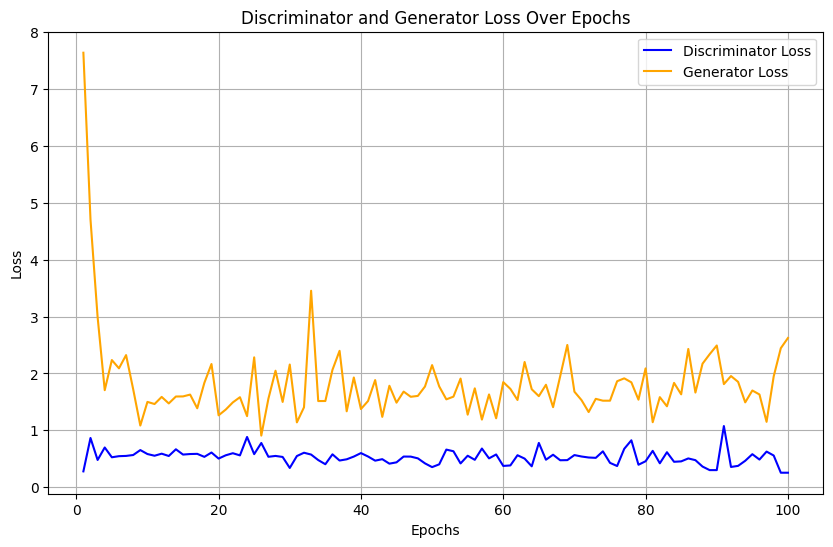

In [5]:
import matplotlib.pyplot as plt

# Data (paste your loss values here)
epochs = list(range(1, 101))
loss_d = [0.2769, 0.8642, 0.4776, 0.6969, 0.5249, 0.5443, 0.5488, 0.5647, 0.6516, 0.5819,
          0.5520, 0.5882, 0.5475, 0.6653, 0.5725, 0.5819, 0.5851, 0.5323, 0.6085, 0.5022,
          0.5596, 0.5962, 0.5582, 0.8821, 0.5802, 0.7763, 0.5337, 0.5485, 0.5306, 0.3369,
          0.5466, 0.6048, 0.5726, 0.4759, 0.4026, 0.5768, 0.4676, 0.4893, 0.5373, 0.5987,
          0.5384, 0.4654, 0.4915, 0.4126, 0.4358, 0.5376, 0.5366, 0.5059, 0.4178, 0.3518,
          0.4006, 0.6600, 0.6309, 0.4166, 0.5521, 0.4802, 0.6785, 0.5057, 0.5742, 0.3726,
          0.3814, 0.5608, 0.5015, 0.3659, 0.7772, 0.4819, 0.5697, 0.4726, 0.4748, 0.5637,
          0.5384, 0.5208, 0.5148, 0.6294, 0.4265, 0.3711, 0.6738, 0.8236, 0.3936, 0.4551,
          0.6379, 0.4191, 0.6136, 0.4456, 0.4528, 0.5046, 0.4741, 0.3615, 0.2992, 0.2992,
          1.0738, 0.3546, 0.3739, 0.4633, 0.5793, 0.4849, 0.6249, 0.5559, 0.2533, 0.2532]

loss_g = [7.6406, 4.7071, 2.9909, 1.7053, 2.2350, 2.0895, 2.3223, 1.7204, 1.0830, 1.4989,
          1.4615, 1.5867, 1.4720, 1.5936, 1.5953, 1.6273, 1.3866, 1.8343, 2.1651, 1.2629,
          1.3635, 1.4901, 1.5816, 1.2486, 2.2825, 0.9062, 1.5558, 2.0474, 1.4980, 2.1560,
          1.1388, 1.4038, 3.4540, 1.5137, 1.5146, 2.0629, 2.3973, 1.3339, 1.9286, 1.3731,
          1.5146, 1.8828, 1.2354, 1.7828, 1.4856, 1.6800, 1.5888, 1.6043, 1.7693, 2.1461,
          1.7711, 1.5438, 1.5911, 1.9090, 1.2742, 1.7374, 1.1877, 1.6301, 1.2105, 1.8468,
          1.7279, 1.5327, 2.2009, 1.7216, 1.5997, 1.8004, 1.4061, 1.9505, 2.5006, 1.6782,
          1.5296, 1.3202, 1.5528, 1.5202, 1.5201, 1.8625, 1.9132, 1.8430, 1.5380, 2.0886,
          1.1415, 1.5826, 1.4217, 1.8333, 1.6318, 2.4299, 1.6630, 2.1709, 2.3372, 2.4911,
          1.8116, 1.9536, 1.8512, 1.4908, 1.6994, 1.6295, 1.1480, 1.9472, 2.4438, 2.6226]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_d, label='Discriminator Loss', color='blue')
plt.plot(epochs, loss_g, label='Generator Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
